In [1]:
# https://langchain-ai.github.io/langgraph/how-tos/create-react-agent-memory/?h=memory
# https://langchain-ai.github.io/langgraph/how-tos/persistence/?h=memo
# https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.base.CheckpointMetadata.step

In [6]:
import os
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage,BaseMessage
from langchain_openai import ChatOpenAI
import operator
from typing import Annotated, TypedDict, List
from langgraph.graph import StateGraph, END, MessageGraph, START
from IPython.display import Image, display
from langchain_community.tools.tavily_search import TavilySearchResults

OPENAI_API_KEY="sk-proj-xxx" # https://platform.openai.com/account/api-keys
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

TAVILY_API_KEY="tvly-yy" # https://tavily.com/account/api-keys

os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

llm = ChatOpenAI(model='gpt-4o')


In [7]:
from langgraph.checkpoint.sqlite import SqliteSaver # type: ignore

# Create an in-memory checkpointer
memory = SqliteSaver.from_conn_string(":memory:")

checkpoint_data = {
    "thread_id": "abc123",  # Unique identifier for the thread
    "thread_ts": "2024-07-10T11:34:28",  # Thread timestamp
    "checkpoint": {
        "id": "unique_checkpoint_id",  # Assuming 'id' is needed
        "state": "current_state_data"
    },
    "metadata": {"timestamp": "2024-07-10T11:34:28"}
}

# Save the checkpoint,  Include thread_ts
saved_config = memory.put(
    config={"configurable": {"thread_id": checkpoint_data["thread_id"], "thread_ts": checkpoint_data["thread_ts"]}},
    checkpoint=checkpoint_data["checkpoint"],
    metadata=checkpoint_data["metadata"]
)


# Retrieve the checkpoint data
config = {"configurable": {"thread_id": checkpoint_data["thread_id"]}}
checkpoints = list(memory.list(config))  # List all checkpoints for the given thread_id

# Print retrieved checkpoints
for checkpoint in checkpoints:
    print(checkpoint)

# retrieved output
# CheckpointTuple(config={'configurable': {'thread_id': 'abc123', 'thread_ts': 'unique_checkpoint_id'}}, # type: ignore
# checkpoint={'id': 'unique_checkpoint_id', 'state': 'current_state_data'},
# metadata={'timestamp': '2024-07-10T11:34:28'},
# parent_config={'configurable': {'thread_id': 'abc123', 'thread_ts': '2024-07-10T11:34:28'}},
# pending_writes=None)


CheckpointTuple(config={'configurable': {'thread_id': 'abc123', 'thread_ts': 'unique_checkpoint_id'}}, checkpoint={'id': 'unique_checkpoint_id', 'state': 'current_state_data'}, metadata={'timestamp': '2024-07-10T11:34:28'}, parent_config={'configurable': {'thread_id': 'abc123', 'thread_ts': '2024-07-10T11:34:28'}}, pending_writes=None)


In [8]:
## For persistent storage, SQLite can be used to save checkpoints.
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver # type: ignore

# Connect to an SQLite database
conn = sqlite3.connect("checkpoints.sqlite")
memory = SqliteSaver(conn)

checkpoint_data = {
    "thread_id": "abc123",  # Unique identifier for the thread
    "thread_ts": "2024-07-10T11:34:28",  # Thread timestamp
    "checkpoint": {
        "id": "unique_checkpoint_id",  # Assuming 'id' is needed
        "state": "current_state_data"
    },
    "metadata": {"timestamp": "2024-07-10T11:34:28"}
}

# Save the checkpoint
saved_config = memory.put(
    config={"configurable": {"thread_id": checkpoint_data["thread_id"], "thread_ts": checkpoint_data["thread_ts"]}},
    checkpoint=checkpoint_data["checkpoint"],
    metadata=checkpoint_data["metadata"]
)

cursor = conn.cursor()

# Retrieve a list of all tables in the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Print the list of tables
print("Tables in the database:", tables)

# let's check the table contents
checkpoint_table=tables[0][0]


# Retrieve all data from the 'checkpoints' table
cursor.execute(f"SELECT * FROM {checkpoint_table};")
all_data = cursor.fetchall()

# Print each row in the table
print("Data in the 'checkpoints' table:")
for row in all_data:
    print(row)


Tables in the database: [('checkpoints',), ('writes',)]
Data in the 'checkpoints' table:
('abc123', 'unique_checkpoint_id', '2024-07-10T11:34:28', b'{"id": "unique_checkpoint_id", "state": "current_state_data"}', b'{"timestamp": "2024-07-10T11:34:28"}')


### Create a graph with and without memory

In [9]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, START
from langchain_community.tools.tavily_search import TavilySearchResults

class State(TypedDict):
    messages: Annotated[list, add_messages]

search = TavilySearchResults(max_results=5)

tools = [search]
tool_node = ToolNode(tools)

llm = ChatOpenAI(model='gpt-4o', streaming=True)
bound_llm = llm.bind_tools(tools)

# Define Graph and components
def should_continue(state: State):
    """Return the next node to execute."""
    last_message = state["messages"][-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "__end__"
    # Otherwise if there is, we continue
    return "action"

# Define the function that calls the model
def call_model(state: State):
    response = llm.invoke(state["messages"])
    # We return a list, because this will get added to the existing list
    return {"messages": response}

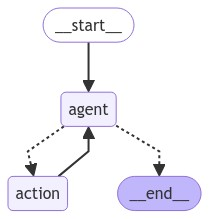

In [16]:
# Define a new graph
workflow = StateGraph(State)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge

workflow.add_conditional_edges(
    "agent", # start from agent node

    should_continue, # apply this condition
)

# We now add a normal edge from `tools` to `agent`.
#  After `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

###### Adding Memory -----------------

from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver.from_conn_string(":memory:")
graph = workflow.compile(checkpointer=memory)

# Without memory
#graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


## Interacting with agent

In [17]:
config = {"configurable": {"thread_id": "0"}}
input_message = HumanMessage(content="What are the best places to visit in St. Louis? Is the Gateway Arch the top attraction?")
graph.invoke({"messages": [input_message]}, config)

{'messages': [HumanMessage(content='What are the best places to visit in St. Louis? Is the Gateway Arch the top attraction?', id='548dd019-8474-4e1c-b1fc-1ee8e7614877'),
  AIMessage(content="St. Louis, Missouri, is a vibrant city with a rich history and plenty of attractions to suit a wide range of interests. Here are some of the best places to visit in St. Louis:\n\n### 1. **Gateway Arch**\nYes, the Gateway Arch is often considered the top attraction in St. Louis. This iconic 630-foot monument symbolizes the westward expansion of the United States and offers stunning views of the city and the Mississippi River from its observation deck.\n\n### 2. **Forest Park**\nOne of the largest urban parks in the United States, Forest Park is home to several major attractions, including:\n- **Saint Louis Art Museum**: Free admission and a vast collection of art.\n- **Saint Louis Zoo**: Also free and considered one of the best zoos in the country.\n- **Missouri History Museum**: Offers exhibits on 

In [18]:
input_message = HumanMessage(content="Which place did I ask about previously?")
graph.invoke({"messages": [input_message]}, config)


{'messages': [HumanMessage(content='What are the best places to visit in St. Louis? Is the Gateway Arch the top attraction?', id='548dd019-8474-4e1c-b1fc-1ee8e7614877'),
  AIMessage(content="St. Louis, Missouri, is a vibrant city with a rich history and plenty of attractions to suit a wide range of interests. Here are some of the best places to visit in St. Louis:\n\n### 1. **Gateway Arch**\nYes, the Gateway Arch is often considered the top attraction in St. Louis. This iconic 630-foot monument symbolizes the westward expansion of the United States and offers stunning views of the city and the Mississippi River from its observation deck.\n\n### 2. **Forest Park**\nOne of the largest urban parks in the United States, Forest Park is home to several major attractions, including:\n- **Saint Louis Art Museum**: Free admission and a vast collection of art.\n- **Saint Louis Zoo**: Also free and considered one of the best zoos in the country.\n- **Missouri History Museum**: Offers exhibits on 

In [19]:
config_new = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="When was the Great Wall of China built?")
graph.invoke({"messages": [input_message]}, config_new)

{'messages': [HumanMessage(content='When was the Great Wall of China built?', id='8f193ea5-a3ad-4393-99fe-38d4ea5eb9a2'),
  AIMessage(content='The construction of the Great Wall of China spans several dynasties, but the most well-known sections were built during the Ming Dynasty (1368–1644). The origins of the wall date back to earlier periods, with initial fortifications constructed as early as the 7th century BCE during the Warring States period. These early walls were built by individual states to defend against invasions.\n\nThe first emperor of a unified China, Qin Shi Huang (r. 221–210 BCE), connected and expanded several of these walls to form a more extensive defense system. However, the majority of the existing wall that we see today, including its most iconic sections, was constructed during the Ming Dynasty to protect against Mongol invasions. The work continued over several centuries, with significant construction efforts occurring from the late 14th century to the 17th cen

In [20]:
input_message = HumanMessage(content="Describe the historical significance of this location.")
graph.invoke({"messages": [input_message]}, config)


{'messages': [HumanMessage(content='What are the best places to visit in St. Louis? Is the Gateway Arch the top attraction?', id='548dd019-8474-4e1c-b1fc-1ee8e7614877'),
  AIMessage(content="St. Louis, Missouri, is a vibrant city with a rich history and plenty of attractions to suit a wide range of interests. Here are some of the best places to visit in St. Louis:\n\n### 1. **Gateway Arch**\nYes, the Gateway Arch is often considered the top attraction in St. Louis. This iconic 630-foot monument symbolizes the westward expansion of the United States and offers stunning views of the city and the Mississippi River from its observation deck.\n\n### 2. **Forest Park**\nOne of the largest urban parks in the United States, Forest Park is home to several major attractions, including:\n- **Saint Louis Art Museum**: Free admission and a vast collection of art.\n- **Saint Louis Zoo**: Also free and considered one of the best zoos in the country.\n- **Missouri History Museum**: Offers exhibits on 

In [21]:
state_history = graph.get_state_history(config)
all_snapshots=[x for x in state_history]

In [22]:
all_snapshots[0].values['messages']


[HumanMessage(content='What are the best places to visit in St. Louis? Is the Gateway Arch the top attraction?', id='548dd019-8474-4e1c-b1fc-1ee8e7614877'),
 AIMessage(content="St. Louis, Missouri, is a vibrant city with a rich history and plenty of attractions to suit a wide range of interests. Here are some of the best places to visit in St. Louis:\n\n### 1. **Gateway Arch**\nYes, the Gateway Arch is often considered the top attraction in St. Louis. This iconic 630-foot monument symbolizes the westward expansion of the United States and offers stunning views of the city and the Mississippi River from its observation deck.\n\n### 2. **Forest Park**\nOne of the largest urban parks in the United States, Forest Park is home to several major attractions, including:\n- **Saint Louis Art Museum**: Free admission and a vast collection of art.\n- **Saint Louis Zoo**: Also free and considered one of the best zoos in the country.\n- **Missouri History Museum**: Offers exhibits on the region’s h